### Import needed packages and scripts

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from datetime import datetime
import pickle, sys, os, json
import astropy.units as u
import copy
import pandas as pd
pd.set_option("display.max_columns", None)

from astropy.coordinates import SkyCoord
from matplotlib.dates    import DayLocator, MonthLocator, DateFormatter
from regions             import PointSkyRegion
from astropy.time        import Time
from scipy.stats         import chi2, norm

from gammapy.modeling.models import create_crab_spectral_model, SkyModel, LogParabolaSpectralModel
from gammapy.estimators      import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.modeling        import Fit
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.makers          import SpectrumDatasetMaker, WobbleRegionsFinder, ReflectedRegionsBackgroundMaker, SafeMaskMaker
from gammapy.maps            import MapAxis, RegionGeom, Map, TimeMapAxis
from gammapy.data            import DataStore

# import scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import plotting

### Paths to data and results

In [2]:
# Root path of this script
root = os.getcwd() + "/"
# Objects directory
root_objects = root + "objects/"
# Data directory
root_data = root + "../../data/"

# Gammapy configuration file
config_gammapy_path = root_objects + "config_gammapy_analysis.json"

# Data labels
dataset_labels = ["Stable runs scaled", "Stable runs"]#["Performance paper period scaled", "Performance paper period", "Performance paper scaled", "Performance paper", "Unstable runs scaled", "Unstable runs", "Stable runs (jump) scaled", "Stable runs (jump)", "Stable runs scaled", "Stable runs", ]
# Color plots
color_plots = ["r", "k",]

# Path of dl3 data
dl3_dirs = [
    "/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_scaled_4/",
    "/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_4/",
]

compute_datasets = False

### Loading configuration files

In [3]:
pkl_paths_dataset    = []
pkl_paths_lightcurve = []
for label in dataset_labels:
    pkl_paths_dataset.append(os.path.join(root, "objects", f"tmp_dataset_{label}.pkl"))
    pkl_paths_lightcurve.append(os.path.join(root, "objects", f"tmp_lightcurve_{label}.pkl"))

# Reading the configuration for gammapy we created
with open(config_gammapy_path, "r") as json_file:
    config_gammapy = json.load(json_file)

# Saving part of the configuration in variables
target_name   = config_gammapy["target_name"]
n_off_regions = config_gammapy["n_off_regions"]
_e_reco = config_gammapy["e_reco"]
_e_true = config_gammapy["e_true"]

e_reco_min, e_reco_max, e_reco_bin_p_dec = _e_reco["min"], _e_reco["max"], _e_reco["bins_p_dec"]
e_true_min, e_true_max, e_true_bin_p_dec = _e_true["min"], _e_true["max"], _e_true["bins_p_dec"]

# Energy for the lightcurve
e_lc_min = config_gammapy["e_lc"]["min"] * u.TeV
e_lc_max = config_gammapy["e_lc"]["max"] * u.TeV

print(f"\nLoading config file...\nSource: {target_name}")
print(f"Reco Energy limits: {_e_reco['min']:}-{_e_reco['max']:} TeV ({_e_reco['bins_p_dec']} bins)")
print(f"True Energy limits: {_e_true['min']:}-{_e_true['max']:} TeV ({_e_true['bins_p_dec']} bins)")
print(f"LC Integration lim: {e_lc_min.value:}-{e_lc_max.value:} TeV")


Loading config file...
Source: crab
Reco Energy limits: 0.1-50 TeV (5 bins)
True Energy limits: 0.01-200 TeV (10 bins)
LC Integration lim: 0.25-50.0 TeV


### Loading full datasets

In [4]:
obs_ids      = [] # All run numbers directly read from the directory
observations = [] # Observation information for each dataset
total_data_stores = []

for dl3_dir in dl3_dirs:
    # Opening all the dl3 data in a path
    total_data_store = DataStore.from_dir(dl3_dir)
    
    # Taking the obs ids
    _obs_ids = total_data_store.obs_table["OBS_ID"].data
    _obs_ids = _obs_ids[:]
    
    # Then we get the observation information from the total data store
    _observations = total_data_store.get_observations(
        _obs_ids,
        required_irf=["aeff", "edisp", "rad_max"]
    )

    obs_ids.append(_obs_ids)
    observations.append(_observations)

    print(f"\nReading {dl3_dir}...\nN runs: {len(_obs_ids)} ({min(_obs_ids)}-{max(_obs_ids)})")
    print(f"Livetime: {total_data_store.obs_table['LIVETIME'].data.sum()/3600:.2f} h")

    total_data_stores.append(total_data_store.obs_table)
display(total_data_store.obs_table[:5])

# Defining target position and ON reion
target_position = SkyCoord.from_name(target_name, frame="icrs")
on_region = PointSkyRegion(target_position)


Reading /fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_scaled_4/...
N runs: 66 (2934-7276)
Livetime: 19.28 h

Reading /fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_4/...
N runs: 66 (2934-7276)
Livetime: 19.46 h


OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes8,int64,bytes5,bytes5
2934,2020-11-19,03:28:42.605,2020-11-19,03:48:24.005,83.2730329507883,21.78675262481,12.72830678496868,77.27169321503132,239.1880275528012,83.6287,22.0147,67404522.60519242,67405704.0045147,1179.3995027542114,1181.399322271347,1109.2829127198497,0.9405489065659085,crab,POINTING,1,LST-1,LST-1
2967,2020-11-21,00:27:41.949,2020-11-21,00:47:39.586,83.9699668536548,22.24541910807181,29.733123938785198,60.2668760612148,95.17520105785535,83.6287,22.0147,67566461.94886518,67567659.58641505,1197.639963388443,1197.6375498771667,1150.8875241389285,0.9609628597251887,crab,POINTING,1,LST-1,LST-1
2968,2020-11-21,00:49:07.551,2020-11-21,01:08:52.836,83.26641051863885,21.787397540498688,24.626370922225917,65.37362907777408,100.45587253577524,83.6287,22.0147,67567747.55105853,67568932.83593297,1182.2857775688171,1185.2848744392395,1134.1542381955712,0.959289420302238,crab,POINTING,1,LST-1,LST-1
2970,2020-11-21,01:31:05.784,2020-11-21,01:50:48.105,83.26917138477232,21.786844479767183,15.802434022925397,74.1975659770746,112.73651710873229,83.6287,22.0147,67570265.78368449,67571448.10494876,1180.3228249549866,1182.3212642669678,1129.300763976495,0.9567727913925266,crab,POINTING,1,LST-1,LST-1
2971,2020-11-21,01:52:06.552,2020-11-21,02:11:57.547,83.97479054112601,22.244913567187204,11.970012909152345,78.02998709084765,120.75693826944863,83.6287,22.0147,67571526.55189061,67572717.54740429,1190.8858170509338,1190.995513677597,1138.0225898291928,0.955610163069496,crab,POINTING,1,LST-1,LST-1


### Defining all the energy axes

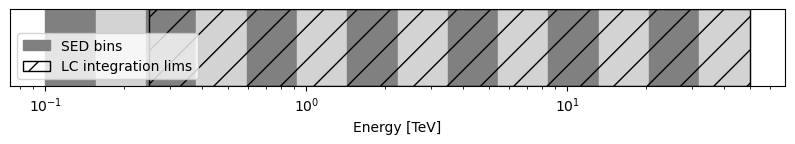

In [5]:
# ============================ #
# estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
# ============================ #
# estimated energy axes
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)
# ============================ #
# Energy for the spectrum
e_fit_min = energy_axis.edges[0].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

# ============================ #

fig, ax = plt.subplots(figsize=(10,1))
for i in range(len(energy_fit_edges)-1):
    if i % 2 == 0:
        ax.axvspan(energy_fit_edges[i].value, energy_fit_edges[i+1].value, color="gray",)
    else:
        ax.axvspan(energy_fit_edges[i].value, energy_fit_edges[i+1].value, color="lightgray")

ax.axvspan(None, None, color="gray", label="SED bins")
ax.axvspan(e_lc_min.value, e_lc_max.value, facecolor="none", edgecolor="k", hatch="/", label="LC integration lims")
ax.set_yticks([])
ax.legend(loc=3)
ax.set_xscale("log")
ax.set_xlabel("Energy [TeV]")
plt.show()

### We define the geometry regions in te sky and prepare the empty datasets and makers

In [6]:
# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_axis]
)


# -------------------------------------------------------
# creating an empty dataset
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_axis_true
)
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"]
)
# -------------------------------------------------------


# tell the background maker to use the WobbleRegionsFinder
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

### Now we analize the ON and OFF regions in the dataset and we store them in `datasets`, then the datasets can be stacked in a unique one

In [7]:
%%time
datasets = []
stacked_datasets = []

for _observations, label, pkl_path in zip(observations, dataset_labels, pkl_paths_dataset):
    if compute_datasets:
        # -------------------------------------------------------
        # The final object will be stored as a Datasets object
        _datasets = Datasets()
        for obs in _observations:
            _dataset = copy.copy(dataset_maker).run(
                dataset=copy.copy(dataset_empty).copy(name=str(obs.obs_id)),
                observation=obs
            )
            dataset_on_off = bkg_maker.run(
                dataset=_dataset, 
                observation=obs
            )
            _datasets.append(dataset_on_off) 

        # Stacking the datasets in one
        _stacked_dataset = Datasets(_datasets).stack_reduce()

        datasets.append(_datasets)
        stacked_datasets.append(_stacked_dataset)
        # -------------------------------------------------------

        # Storing objects
        with open(pkl_path, 'wb') as f:
            pickle.dump(_datasets, f, pickle.HIGHEST_PROTOCOL)
    else:
        with open(pkl_path, "rb") as f:
            _datasets = pickle.load(f)
        _stacked_dataset = Datasets(_datasets).stack_reduce()
        
        datasets.append(_datasets)
        stacked_datasets.append(_stacked_dataset)
        
    print(f"dataset = {label}")
    print(_stacked_dataset)

dataset = Stable runs scaled
SpectrumDatasetOnOff
--------------------

  Name                            : giDwXMu0 

  Total counts                    : 176759 
  Total background counts         : 135385.00
  Total excess counts             : 41374.00

  Predicted counts                : 156072.00
  Predicted background counts     : 156072.00
  Predicted excess counts         : nan

  Exposure min                    : 4.65e+04 m2 s
  Exposure max                    : 1.44e+10 m2 s

  Number of total bins            : 14 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16599.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 135385 
  Acceptance                      : 14 
  Acceptance off                  : 14 

dataset = Stable runs
SpectrumDatasetOnOff
--------------------

  Name                            : 

### Then we define the model and set it inside the dataset

In [8]:
# defining the model we want to fit and the starting values
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
# we will use the crab model in general
models = []
for stacked_dataset in stacked_datasets:
    _model = SkyModel(
        spectral_model=spectral_model, 
        name="crab"
    )
    # We set the model of all datasets to log parabola
    stacked_dataset.models = _model
    models.append(_model)

### We fit the model with the stacked dataset

In [9]:
best_fit_models = []

for stacked_dataset, model in zip(stacked_datasets, models):
    # Now we run the fit to extract the parameters of the model
    fit = Fit()
    result = fit.run(datasets=stacked_dataset)
    best_fit_model = model
    display(stacked_dataset.models.to_parameters_table())

    best_fit_models.append(best_fit_model.copy())

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
crab,,amplitude,4.0650e-11,TeV-1 s-1 cm-2,4.927e-13,nan,nan,False,True,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
crab,,alpha,2.4608e+00,,1.140e-02,nan,nan,False,False,,
crab,,beta,9.7187e-02,,8.039e-03,nan,nan,False,False,,


model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
crab,,amplitude,4.1219e-11,TeV-1 s-1 cm-2,4.961e-13,nan,nan,False,True,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
crab,,alpha,2.4614e+00,,1.163e-02,nan,nan,False,False,,
crab,,beta,1.0359e-01,,8.353e-03,nan,nan,False,False,,


### Then from the model and the data we can extract the flux points

In [10]:
%%time
# then extracting the flux points from the data
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    source=target_name, 
    selection_optional="all"
)

flux_points = []
for stacked_dataset in stacked_datasets:
    fpe = FluxPointsEstimator(
        energy_edges=energy_fit_edges, 
        source=target_name, 
        selection_optional="all"
    )
    
    # We apply the flux point estiation from the datasets
    _flux_points = fpe.run(datasets=stacked_dataset)
    display(_flux_points.to_table(sed_type="dnde", formatted=True)[:3])
    flux_points.append(_flux_points)


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.125,0.100,0.156,4.268e-09,1.779e-10,1.781e-10,1.781e-10,4.624e-09,574.539,23.970,125069.982302475,11701.966,0.000,574.539,False,125070.0,True,0.200 .. 5.000,361.624 .. 9715.496
0.195,0.156,0.243,1.775e-09,3.578e-11,3.579e-11,3.576e-11,1.847e-09,2488.049,49.880,25353.950100789283,10010.92,0.000,2488.049,False,25354.0,True,0.200 .. 5.000,1606.242 .. 27444.649
0.303,0.243,0.379,6.761e-10,1.128e-11,1.129e-11,1.126e-11,6.987e-10,3744.075,61.189,11807.905323294246,7590.8716,0.000,3744.075,False,11808.0,True,0.200 .. 5.000,2434.463 .. 28717.718


e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool,float64[11],float64[11]
0.125,0.100,0.156,4.142e-09,1.795e-10,1.794e-10,1.794e-10,4.501e-09,532.991,23.087,129064.93856401625,11463.883,0.000,532.991,False,129065.0,True,0.200 .. 5.000,330.179 .. 9715.690
0.195,0.156,0.243,1.777e-09,3.586e-11,3.587e-11,3.584e-11,1.849e-09,2482.063,49.820,25893.94124801855,10118.905,0.000,2482.063,False,25894.0,True,0.200 .. 5.000,1603.144 .. 27466.944
0.303,0.243,0.379,6.836e-10,1.128e-11,1.129e-11,1.127e-11,7.062e-10,3824.458,61.842,12053.520485340365,7750.349,0.000,3824.458,False,12054.0,True,0.200 .. 5.000,2500.082 .. 28732.998


CPU times: user 8.67 s, sys: 2.22 s, total: 10.9 s
Wall time: 10.9 s


### Then we can plot the SED

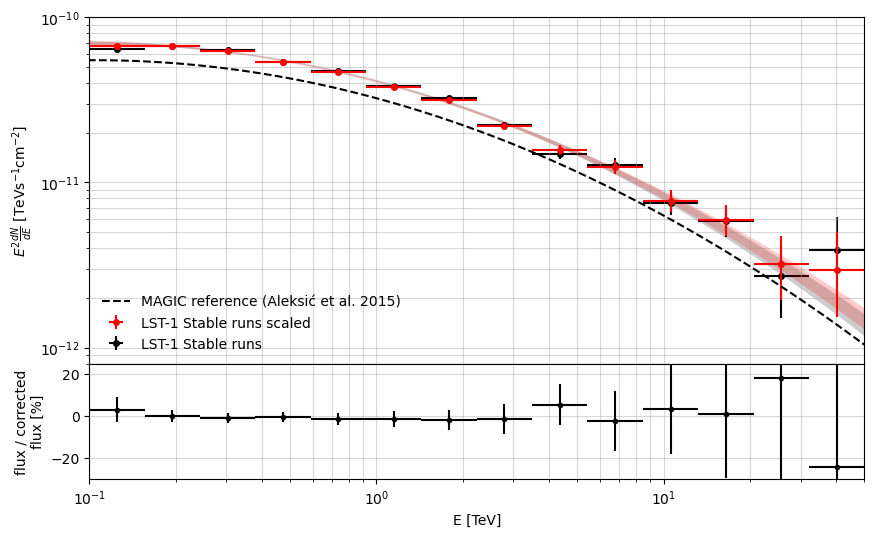

In [11]:
plot_kwargs = {
    "energy_bounds": [0.08, 100] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.TeV,
}
cmap = plotting.create_cmap_from_colors(["w", "w", "cornflowerblue"])

# Crab models
crab_magic_100 = create_crab_spectral_model("magic_lp")

# ----------------------------------------------------------
fig, (ax, axr) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

for i in range(len(color_plots)):
    best_fit_models[i].spectral_model.plot_error(
        ax=ax, facecolor=color_plots[i], alpha=0.2, **plot_kwargs, zorder=len(color_plots)-i
    )
    flux_points[i].plot(
        sed_type="e2dnde", ax=ax, color=color_plots[i], label=f"LST-1 {dataset_labels[i]}",
        zorder=len(color_plots)-i
    )

crab_magic_100.plot(
    ax=ax, ls="--", lw=1.5, color="k", label="MAGIC reference (Aleksić et al. 2015)", **plot_kwargs
)

tab_scaled = flux_points[0].to_table(sed_type="dnde", formatted=True)
tab_origin = flux_points[1].to_table(sed_type="dnde", formatted=True)

ratio = np.array(tab_scaled["dnde"] / tab_origin["dnde"])
e_ratio = np.sqrt((tab_origin["dnde"] * tab_origin["dnde_err"] / tab_scaled["dnde"]**2)**2 + (tab_scaled["dnde_err"] / tab_scaled["dnde"])**2)

energy = np.array(tab_origin["e_ref"])
axr.errorbar(
    energy, (ratio - 1) * 100, xerr=(energy - tab_scaled["e_min"], tab_scaled["e_max"] - energy), yerr=(e_ratio) * 100,
    color="k", ls="", marker="."
)
axr.set_ylim(-30, 25)
ax.legend(loc=3, frameon=False)
ax.set_ylim([8e-13, 1e-10])
ax.grid(which="both", alpha=0.5)
axr.grid(which="both", alpha=0.5)
ax.set_ylabel("$E^2\\frac{dN}{dE}$ [TeVs${}^{-1}$cm${}^{-2}$]")
axr.set_xlabel("E [TeV]")
axr.set_ylabel("flux / corrected\nflux [%]")
plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=400)
plt.show()

### Then once we have found the SED model we fix the alpha and beta parameters and let the amplitude as a free parameter

In [12]:
# Create the LC Estimator for each run
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source="crab", 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

for dataset, model in zip(datasets, models):
    model.parameters["alpha"].frozen = True
    model.parameters["beta"].frozen  = True
    # Assigning the fixed parameters model to each dataset
    for data in dataset:
        data.models = model

### Then we run the lightcurve maker run-wise

In [13]:
%%time
print(f"LC will be estimated from {e_lc_min:} to {e_lc_max:} TeV")
lcs_runwise = []
lightcurves = []

for pkl_path, dataset in zip(pkl_paths_lightcurve, datasets):
    if compute_datasets:
        _lc_runwise = lc_maker_1d.run(dataset)
        # Storing object
        with open(pkl_path, 'wb') as f:
            pickle.dump(_lc_runwise, f, pickle.HIGHEST_PROTOCOL)
    else:
        with open(pkl_path, "rb") as f:
            _lc_runwise = pickle.load(f)
    _lightcurve = _lc_runwise.to_table(sed_type="flux", format="lightcurve")
    
    lcs_runwise.append(_lc_runwise)
    lightcurves.append(_lightcurve)

LC will be estimated from 0.25 TeV to 50.0 TeV TeV
CPU times: user 4.16 s, sys: 129 ms, total: 4.29 s
Wall time: 4.29 s


### We calculate the mean flux and the statistical error
##### Calculating the means, errors, $\chi^2$ and $p$ values

In [14]:
def weighted_average(table, sys_error=0):
    nanmask = ~(np.isnan(table["flux"]) | np.isnan(table["flux_err"]))
    val = table["flux"][nanmask]
    uncertainty = np.sqrt((sys_error * table["flux"][nanmask])**2 + table["flux_err"][nanmask]**2)
    return (val/uncertainty**2).sum() / (1/uncertainty**2).sum(), np.sqrt(1/np.sum(1/uncertainty**2))

def calculate_chi2_pvalue(table, sys_error=0):
    uncertainty = np.sqrt((sys_error * table["flux"])**2 + table["flux_err"]**2)
    flux = table["flux"]
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    print(f"Weighted mean flux: {mean_flux:.3e} +/- {mean_flux_err:.3e} cm-2 s-1")
    
    chi2_value = np.sum((table["flux"] - mean_flux)**2/uncertainty**2)
    ndf = len(table["flux"]) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    print(f"Chi2: {chi2_value:.1f}, ndf: {ndf}, P-value: {pvalue:.2e}")
    return chi2_value, ndf, pvalue

mean_flux = []
mean_flux_err = []
chi2_val, pvalue, ndf = [], [], []
for lightcurve, label in zip(lightcurves, dataset_labels):
    _mean_flux, _mean_flux_err = weighted_average(lightcurve)
    print(f"\nFor {label} analysis")
    _chi2_val, _ndf, _pvalue = calculate_chi2_pvalue(lightcurve, sys_error=0.0)
    mean_flux.append(_mean_flux)
    mean_flux_err.append(_mean_flux_err)
    chi2_val.append(_chi2_val)
    pvalue.append(_pvalue)
    ndf.append(_ndf)


For Stable runs scaled analysis
Weighted mean flux: 1.986e-10 +/- 1.802e-12 cm-2 s-1
Chi2: 98.1, ndf: 65, P-value: 4.97e-03

For Stable runs analysis
Weighted mean flux: 2.002e-10 +/- 1.803e-12 cm-2 s-1
Chi2: 119.0, ndf: 65, P-value: 5.10e-05


### Extracting the data from the table as arrays

In [15]:
time_min, time_max = [], []
delta_time, time_center = [], []
flux, flux_stat_err = [], []
run_num = []
for observation, lightcurve in zip(observations, lightcurves):
    _time_min = Time(np.hstack(lightcurve["time_min"]), format='mjd').datetime
    _time_max = Time(np.hstack(lightcurve["time_max"]), format='mjd').datetime
    time_min.append(_time_min)
    time_max.append(_time_max)
    delta_time.append(_time_max - _time_min)
    time_center.append(_time_min + (_time_max - _time_min) / 2)
    # Flux and flux error
    flux.append(np.hstack(lightcurve["flux"]))
    flux_stat_err.append(np.hstack(lightcurve["flux_err"]))
    # run numbers
    run_num.append([int(n) for n in observation.ids])


### The Crab Nebula reference from MAGIC

In [16]:
crab = create_crab_spectral_model("magic_lp")

crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab = crab.integral(e_lc_min, e_lc_max)
flux_crab_error = flux_crab * 0

### Plotting the LC

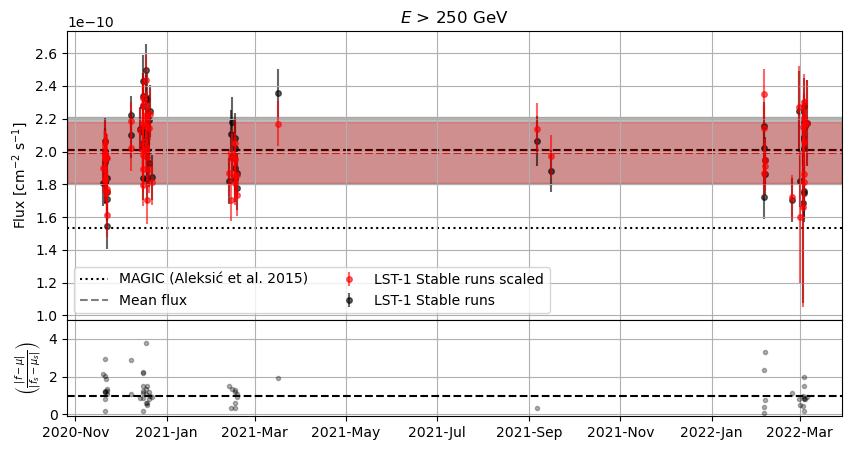

In [40]:
fig, (ax, axr) = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

for i in range(len(lightcurves))[:]:
    ax.errorbar(
        time_center[i], flux[i], yerr=flux_stat_err[i], color=color_plots[i], 
        ls="", marker=".", ms=8, label=f"LST-1 {dataset_labels[i]}", zorder=len(lightcurves)-i, alpha=0.6
    )
    
    # Mean flux + error
    ax.axhline(np.nanmean(flux[i]), ls="--", color=color_plots[i], zorder=len(lightcurves)-i-100,)
    ax.axhspan(np.nanmean(flux[i]) - np.nanstd(flux[i]), np.nanmean(flux[i]) + np.nanstd(flux[i]), 
               color=color_plots[i], alpha=0.25,zorder=len(lightcurves)-i-100)

# "residuals" plot
r = np.abs(flux[1] - np.nanmean(flux[1])) / np.abs(flux[0] - np.nanmean(flux[0]))
axr.plot(time_center[0], r, ls="", marker=".", color="k", alpha=0.3,)

# MAGIC reference
ax.axhline(flux_crab.value, ls=":", color="k", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

axr.axhline(1, ls="--", color="k")
ax.plot([], [], ls="--", color="gray", label="Mean flux")

ax.set_title(f"$E$ > {e_lc_min.to('GeV'):.0f}")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date]")
axr.set_ylabel("$\\left(\\frac{|f-\mu|}{|f_s-\mu_s|}\\right)$")
ax.legend(loc=3, frameon=True, ncols=2)
ax.xaxis.set_major_locator(MonthLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%b"))
for axe in [ax, axr]:
    axe.grid()
axr.set_ylim(-0.1, 5)
plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

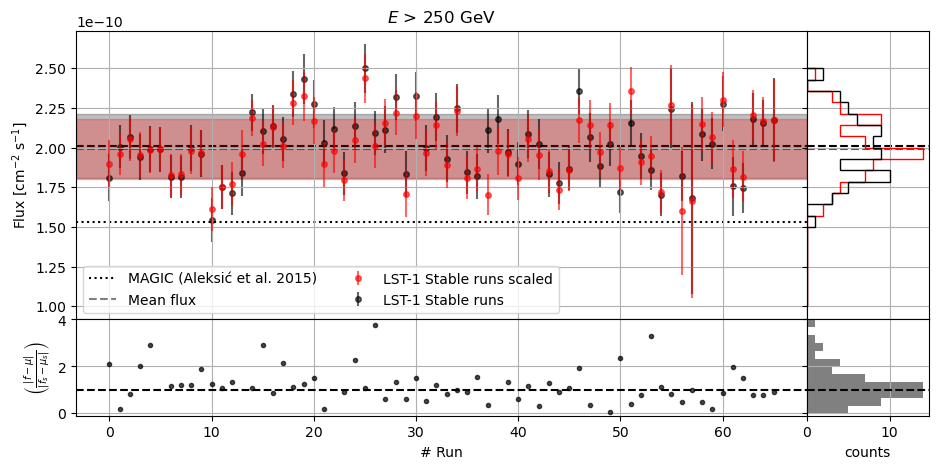

In [41]:
fig, ((ax, axh), (axr, axrh)) = plt.subplots(
    2, 2, figsize=(11, 5), gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [6, 1]}, sharey="row", sharex="col")

for i in range(len(lightcurves))[:]:
    ax.errorbar(
        np.arange(len(flux[i])), flux[i], yerr=flux_stat_err[i], color=color_plots[i], 
        ls="", marker=".", ms=8, label=f"LST-1 {dataset_labels[i]}", zorder=len(lightcurves)-i, alpha=0.6
    )
    
    # Mean flux + error
    for axe in [ax, axh]:
        axe.axhline(np.nanmean(flux[i]), ls="--", color=color_plots[i], zorder=len(lightcurves)-i-100,)
    ax.axhspan(np.nanmean(flux[i]) - np.nanstd(flux[i]), np.nanmean(flux[i]) + np.nanstd(flux[i]), 
               color=color_plots[i], alpha=0.25,zorder=len(lightcurves)-i-100)

    # Plotting histograms
    axh.hist(flux[i], bins=np.linspace(1e-10, 2.5e-10, 22), color=color_plots[i], histtype="step", orientation="horizontal")

# "residuals" plot
r = np.abs(flux[1] - np.nanmean(flux[1])) / np.abs(flux[0] - np.nanmean(flux[0]))
axr.plot(np.arange(len(flux[0])), r, ls="", marker=".", color="k", alpha=0.7,)
axrh.hist(r, bins=np.linspace(0, 4, 13), color="gray", orientation="horizontal")

# MAGIC reference
ax.axhline(flux_crab.value, ls=":", color="k", zorder=-1, label="MAGIC (Aleksić et al. 2015)")

ax.plot([], [], ls="--", color="gray", label="Mean flux")

ax.set_title(f"$E$ > {e_lc_min.to('GeV'):.0f}")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
axr.set_xlabel("# Run")
axr.set_ylabel("$\\left(\\frac{|f-\mu|}{|f_s-\mu_s|}\\right)$")
axrh.set_xlabel("counts")
ax.legend(loc=3, frameon=True, ncols=2)
for axe in [ax, axr, axh, axrh]:
    axe.grid()
for axe in [axr, axrh]:
    axe.axhline(1, ls="--", color="k")  
axr.set_ylim(-0.1, 4)
plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

### Scaling comparisons
Reading first the scaling values

In [58]:
intensity_scalings = []
for obs in obs_ids[:]:
    _scaling = []
    for run in obs:
        files = glob.glob(f"../data_processing_srunwise/objects/final_results_fits/*{run}.pkl")

        with open(files[0], 'rb') as f:
            _dict = pickle.load(f)
            _scaling.append(np.mean([_dict["scaled"]["final"][key] for key in _dict["scaled"]["final"].keys()]))

    intensity_scalings.append(_scaling)

intensity_scaling = intensity_scalings[0]

gamma_scaling = np.nanmean(flux[1]) / flux[1]
gamma_scaling_scaled = np.nanmean(flux[0]) / flux[0]

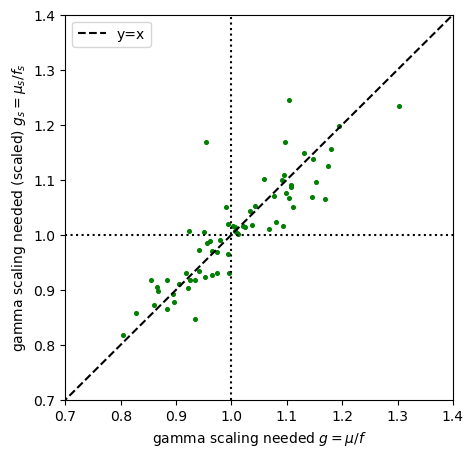

In [119]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(gamma_scaling, gamma_scaling_scaled, s=7, c="g", label="")
ax.axhline(1, color="k", ls=":")
ax.axvline(1, color="k", ls=":")
ax.plot([0, 2], [0, 2], color="k", ls="--", label="y=x")
plt.xlim([0.7, 1.4])
plt.ylim([0.7, 1.4])
ax.legend()
ax.set_xlabel("gamma scaling needed $g=\mu/f$")
ax.set_ylabel("gamma scaling needed (scaled) $g_s=\mu_s/f_s$")
ax.grid()
plt.show()

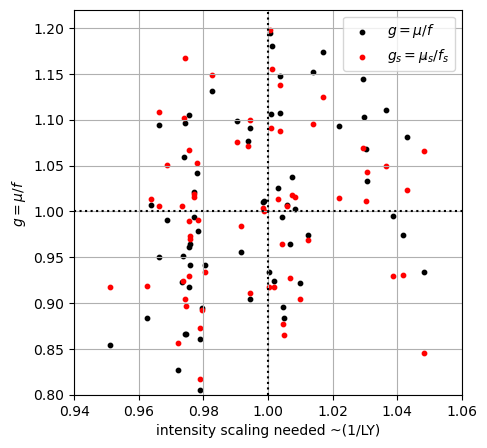

In [124]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(intensity_scaling, gamma_scaling, s=10, c="k", label="$g=\mu/f$")
ax.scatter(intensity_scaling, gamma_scaling_scaled, s=10, c="r", label="$g_s=\mu_s/f_s$")
ax.legend()

ax.axhline(1, color="k", ls=":")
ax.axvline(1, color="k", ls=":")
# ax.plot([0, 2], [0, 2], color="k", ls="--")
plt.xlim([0.94, 1.06])
plt.ylim([0.8, 1.22])
ax.set_xlabel("intensity scaling needed ~(1/LY)")
ax.set_ylabel("$g=\mu/f$")
ax.grid()
plt.show()

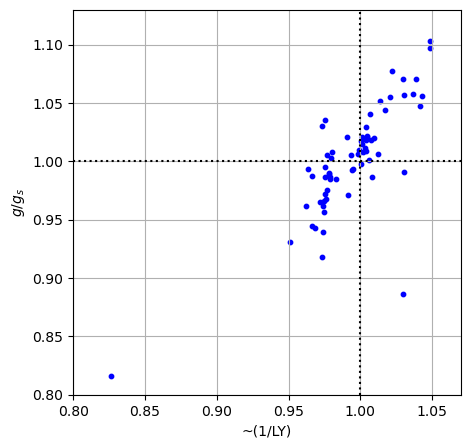

In [123]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(intensity_scaling, gamma_scaling / gamma_scaling_scaled, s=10, c="b", label="")
ax.grid()
ax.axhline(1, color="k", ls=":")
ax.axvline(1, color="k", ls=":")
# ax.plot([0, 2], [0, 2], color="k", ls="--")
plt.xlim([0.8, 1.07])
plt.ylim([0.8, 1.13])
ax.set_xlabel("~(1/LY)")
ax.set_ylabel("$g/g_s$")
plt.show()

In [23]:
a = np.sort(glob.glob("/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_0/*.fits"))
ar = [int(f.split("Run")[-1].split(".")[0]) for f in a]
b = np.sort(glob.glob("/fefs/aswg/workspace/juan.jimenez/data/cherenkov_transparency_corrections/crab/dl3_scaled_0/*.fits"))
br = [int(f.split("Run")[-1].split(".")[0]) for f in b]
for r in ar:
    if r not in br:
        print(r)

In [24]:
for o, f in zip(obs_ids[0], flux[0]):
    if f < 0.5e-10:
        print(o, f"{f:.2e}")

### Plotting the LC run-wise

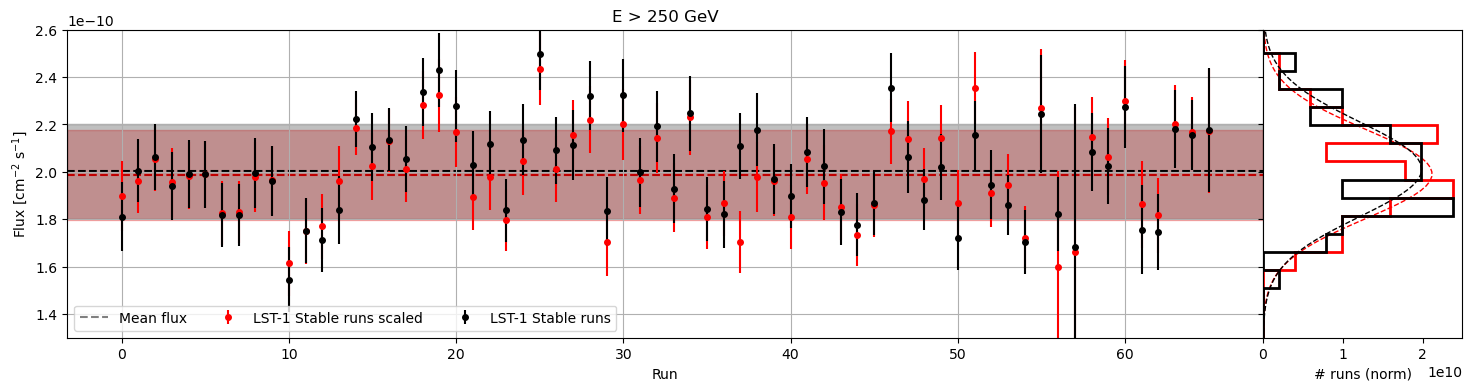

In [25]:
fig, (ax, axv) = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [6, 1]}, sharey=True)

# Plotting the Light Curve
for i in range(len(lightcurves))[:]:

    nanmask = (~np.isnan(flux[i]) & ~np.array([f>4.5e-10 or f<0.1e-10 for f in flux[i]]))
    xplot, yplot, yerrplot = np.arange(len(flux[i]))[nanmask], flux[i][nanmask], flux_stat_err[i][nanmask]
    ax.errorbar(xplot, yplot, yerr=yerrplot, color=color_plots[i], ls="", marker=".", ms=8, 
                label=f"LST-1 {dataset_labels[i]}")
    
    # Mean flux + error
    ax.axhline(mean_flux[i], ls="--", color=color_plots[i], zorder=-1,)
    ax.axhspan(mean_flux[i] - np.std(flux[i]), mean_flux[i] + np.std(flux[i]), color=color_plots[i], alpha=0.25, zorder=-1)

ax.plot([], [], ls="--", color="gray", label="Mean flux")

energy_range = f"{e_lc_min:.2f} < $E$ < {e_lc_max:.0f}"
#####ax.set_title(f"Light curve of {target_name} ({energy_range})")
ax.set_title(f"E > 250 GeV")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Run")
ax.legend(loc=3, frameon=True, ncols=4)
ax.grid()

# ax.set_ylim(0)

# ax.set_ylim(0, 4e-10)
bins = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 24)

for i in range(len(flux))[:]:

    nanmask = (~np.isnan(flux[i]) & ~np.array([f>4.5e-10 or f<0.1e-10 for f in flux[i]]))
    xplot, yplot, yerrplot = np.arange(len(flux[i]))[nanmask], flux[i][nanmask], flux_stat_err[i][nanmask]
    
    axv.hist(yplot, bins, color=color_plots[i], histtype="step", orientation="horizontal", lw=2, density=True,)
    mu, std1 = norm.fit(yplot)
    xmin, xmax = axv.get_ylim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std1)
    axv.plot(p, x, color=color_plots[i], linewidth=1, ls="--")

axv.set_xlabel("# runs (norm)")

ax.set_ylim(1.3e-10, 2.6e-10)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [26]:
# f1 = "flux_info_original.txt"
# f2 = "flux_info_scaled.txt"

# obj1 = np.array([obs_ids[0], flux[0], flux_stat_err[0]])
# obj2 = np.array([obs_ids[1], flux[1], flux_stat_err[1]])

# # with open(f1, "wb") as f:
# np.savetxt(f1, obj1, )
# np.savetxt(f2, obj2, )

# obs_id, flux, flux_err = np.loadtxt("flux_info_original.txt")
# obs_id_scaled, flux_scaled, flux_err_scaled = np.loadtxt("flux_info_scaled.txt")

In [27]:
def calculate_chi2_pvalue_array(flux, flux_err, sys_error=0):
    uncertainty = np.sqrt((sys_error * flux)**2 + flux_err**2)
    mean_flux = (flux/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    
    chi2_value = np.sum((flux - mean_flux)**2/uncertainty**2)
    ndf = len(flux) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    return chi2_value, ndf, pvalue

Niter = 1000
sys = np.linspace(0, 0.20, Niter)
chi2_sys, pvalue_sys, sigma_sys = [], [], []

for i in range(len(flux)):
    
    nanmask = (~np.isnan(flux[i]) & ~np.array([f>4.5e-10 or f<0.1e-10 for f in flux[i]]))
    xplot, yplot, yerrplot = np.arange(len(flux[i]))[nanmask], flux[i][nanmask], flux_stat_err[i][nanmask]
    
    _chi2_sys, _pvalue_sys, _sigma_sys = [], [], []
    
    for s in sys:

        _chi2_value, _ndf, _pvalue = calculate_chi2_pvalue_array(yplot, yerrplot, sys_error=s)
    
        _chi2_sys.append(_chi2_value)
        _pvalue_sys.append(_pvalue)
        _sigma_sys.append(norm.ppf(1 - _pvalue))
    chi2_sys.append(_chi2_sys)
    pvalue_sys.append(_pvalue_sys)
    sigma_sys.append(_sigma_sys)
    

In [28]:
# sys_error = []
# for i in range(len(flux)):
#     # Calculating the systematic error and the difference
#     for j in range(len(sys)-1):
#         if pvalue_sys[i][j] < 0.5 and pvalue_sys[i][j+1] >= 0.5:
#             flag = j
#     sys_error.append(sys[flag])
#     print(f"Systematic uncertainty ({dataset_labels[i]}) = {sys[flag]*100:.2f}%")

# fig, ax = plt.subplots(figsize=(6,4))

# for i in range(len(sigma_sys)):
#     ax.plot(sys*100, pvalue_sys[i], color=color_plots[i], label=f"{dataset_labels[i]}")
    
# ax.set_ylabel("p-value")
# ax.set_xlabel("Systematic error [%]")
# ax.grid()
# ax.legend()
# # plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
# plt.show()


Systematic uncertainty (Stable runs scaled) = 5.21%

Systematic uncertainty (Stable runs) = 6.59%


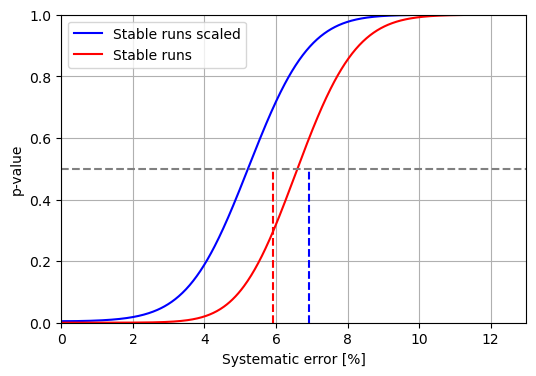

In [29]:
sys_error = []
for i in range(len(flux)):
    # Calculating the systematic error and the difference
    for j in range(len(sys)-1):
        if pvalue_sys[i][j] < 0.5 and pvalue_sys[i][j+1] >= 0.5:
            flag = j
    sys_error.append(sys[flag])
    print(f"\nSystematic uncertainty ({dataset_labels[i]}) = {sys[flag]*100:.2f}%")

fig, ax = plt.subplots(figsize=(6,4))

color_ = ["b", "r", "darkorange", "darkorange", "g", "g"]
lss = ["-", "-", "--", "-", "--", "-"]
for i in range(len(sigma_sys)):
    ax.plot(sys*100, pvalue_sys[i], color=color_[i], ls = lss[i], label=f"{dataset_labels[i]}")

ax.axhline(0.5, ls="--", color="gray", )
ax.plot([6.93, 6.93], [0, 0.5], "--", color="b")
ax.plot([5.915, 5.915], [0, 0.5], "--", color="r")

ax.set_ylabel("p-value")
ax.set_xlabel("Systematic error [%]")
ax.grid()
ax.legend()
ax.set_xlim(0, 13)
ax.set_ylim(0, 1)

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [30]:
r2 = flux[1] / flux[0]
r3 = flux[3] / flux[2]
r4 = flux[5] / flux[4]

IndexError: list index out of range

In [ ]:
obs_ids[0]

scalings = []
for obs in obs_ids[:]:
    _scaling = []
    for run in obs:
        file = glob.glob(f"../data_processing_srunwise/objects/_final_results_fits/*{run}.pkl")[0]
        with open(file, 'rb') as f:
            _dict = pickle.load(f)
            _scaling.append(np.mean([_dict["scaled"]["final"][key] for key in _dict["scaled"]["final"].keys()]))

    scalings.append(_scaling)
s2 = scalings[0]
s3 = scalings[2]
s4 = scalings[4]

In [ ]:
np.std(s4)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(s2, r2, s=15, c="r", label="Unstable")
plt.scatter(s3, r3, s=15, c="darkorange", label="Stable + Jumps")
plt.scatter(s4, r4, s=4, c="g", label="Stable")
ax.legend()
#plt.plot([0.7, 1.2], [0.7, 1.2], color="k", ls="--")
plt.xlim([0.8, 1.1])
plt.ylim([0.7, 1.2])
plt.axhline(1, color="k", ls=":")
plt.axvline(1, color="k", ls=":")
plt.xlabel("Correction applied (intensity)")
plt.ylabel("Correction produced (gamma-ray)")
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(s2, r2, s=15, c="r", label="Unstable")
plt.scatter(s3, r3, s=15, c="darkorange", label="Stable + Jumps")
plt.scatter(s4, r4, s=4, c="g", label="Stable")
ax.legend()
#plt.plot([0.75, 1.2], [0.75, 1.2], color="k", ls="--")
plt.xlim([0.8, 1.1])
plt.ylim([0.95, 1.05])
plt.axhline(1, color="k", ls=":")
plt.axvline(1, color="k", ls=":")
plt.xlabel("Correction applied (intensity)")
plt.ylabel("Correction produced (gamma-ray)")
plt.show()

In [ ]:
residuals = [np.array(f) - np.mean(f) for f in flux]

zenith2 = np.array(total_data_stores[0]["ZEN_PNT"])
zenith3 = np.array(total_data_stores[2]["ZEN_PNT"])
zenith4 = np.array(total_data_stores[4]["ZEN_PNT"])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(zenith2, residuals[1], ls="", color="r", marker="x")
plt.plot(zenith2, residuals[0], ls="", color="r", marker="o", label="Ustable")

plt.plot(zenith3, residuals[2], ls="", color="darkorange", marker="x")
plt.plot(zenith3, residuals[3], ls="", color="darkorange", marker="o", label="Stable + Jumps")

plt.plot(zenith4, residuals[4], ls="", color="g", marker="x")
plt.plot(zenith4, residuals[5], ls="", color="g", marker="o", label="Stable")

ax.plot([], [], color="gray", marker="o", ls="", label="Original")
ax.plot([], [], color="gray", marker="x", ls="", label="Scaled")
ax.axhline(0, ls="--", color="k")

ax.set_xlabel("ZD [deg]")
ax.set_ylabel(f"Residuals (flux - $\mu$)")
ax.grid()
ax.legend()
ax.set_title(f"Residuals vs Zenith")

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(zenith2, r2, ls="", color="r", marker="o", label="Ustable")
plt.plot(zenith3, r3, ls="", color="darkorange", marker="o", label="Stable + Jumps")
plt.plot(zenith4, r4, ls="", color="g", marker="o", label="Stable")

ax.axhline(1, ls="--", color="k")

ax.set_xlabel("ZD [deg]")
ax.set_ylabel("Flux ratio (corrected/original)")
ax.grid()
ax.legend()
ax.set_title(f"Corrections ratio vs Zenith")

plt.show()

In [ ]:
%%time
# Add a progress #################

N = 10000

# corrections
corrections = flux[1] / flux[0]

iter_fluxes = []
chi2_i, pvalue_i, sigma_i = [], [], []
sys_i = []
for i in range(N):

    if i % 500 == 0:
        print(f"{i}/{N} - {i/N * 100:.2f}%")

    mask = np.random.permutation(range(len(flux[0])))

    f = flux[0] * corrections[mask]
    uf = flux_stat_err[0]
    
   

    _chi2_sys, _pvalue_sys, _sigma_sys = [], [], []
    for s in sys:
        _chi2_value, _ndf, _pvalue = calculate_chi2_pvalue_array(f, uf, sys_error=s)
    
        _chi2_sys.append(_chi2_value)
        _pvalue_sys.append(_pvalue)
        _sigma_sys.append(norm.ppf(1 - _pvalue))
    chi2_i.append(_chi2_sys)
    pvalue_i.append(_pvalue_sys)
    sigma_i.append(_sigma_sys)

    iter_fluxes.append(f)

    
    for j in range(len(_pvalue_sys)-1):
        if _pvalue_sys[j] < 0.5 and _pvalue_sys[j+1] >= 0.5:
            flag = j
    sys_i.append(sys[flag])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), )

ax1.hist(np.array(sys_i)*100, bins=30, color="lightgray", density=True)
ax2.hist(np.array(chi2_i)[:,0], bins=30, color="lightgray", density=True, label="10000 repetitions")
for i in range(len(sys_error))[:2]:
    ax1.axvline(sys_error[i] * 100, color=color_plots[i], label=dataset_labels[i], ls="--")
    ax2.axvline(chi2_sys[i][0], color=color_plots[i], label=dataset_labels[i], ls="--")


mu1, std1 = norm.fit(np.array(sys_i)*100)
xmin, xmax = ax1.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu1, std1)
ax1.plot(x, p, color="k", ls="-")

mu2, std2 = norm.fit(np.array(chi2_i)[:,0])
xmin, xmax = ax2.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu2, std2)
ax2.plot(x, p, color="k", ls="-")

ax1.set_ylabel("normalized counts")
fig.suptitle(f"{N} simulations")
ax1.set_xlabel("systematic uncertainty [%]")
ax2.set_xlabel("$\\chi^2$")
ax1.legend()
ax2.legend(loc=1)

fig.tight_layout()

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
import scipy.stats as stats
z_score = (chi2_sys[1][0] - mu2) / std2

probability = stats.norm.cdf(z_score)
print("probability = ", 100-probability * 100, "%")

nmax = 0
for s in np.array(chi2_i)[:,0]:
    if s <= chi2_sys[1][0]:
        nmax = nmax + 1
print(f"result      = {nmax}/{N}, {nmax/N*100:.3f}%")

In [ ]:
import scipy.stats as stats
z_score = (sys_error[1] * 100 - mu1) / std1

probability = stats.norm.cdf(z_score)
print("probability = ", 100-probability * 100, "%")

nmax = 0
for s in np.array(sys_i)*100:
    if s <= sys_error[1]*100:
        nmax = nmax + 1
print(f"result      = {nmax}/{N}, {nmax/N*100:.3f}%")

### Now we put all inside a dict and we store it in a file

In [ ]:
# dict_total = {
    
#     "dict_model" : best_fit_model.to_dict(), # SkyModel.from_dict(<>)
    
#     "table_sed"  : flux_points.to_table(),   # FluxPoints.from_table(<>)

#     "lightcurve" : {

#         "run_number" : run_num,
#         "t_start"    : time_min,
#         "t_stop"     : time_max,
#         "timedelta"  : delta_time,
#         "flux"       : flux_lst1,
#         "e_flux"     : flux_stat_err_lst1,
        
#         "global" : {
#             "e_min"               : e_lc_min,
#             "e_max"               : e_lc_max,
#             "n_off_regions"       : n_off_regions,
#             "target_name"         : target_name,
#             "crab_reference_flux" : flux_crab,
#             "chi2"                : chi2_val,
#             "pvalue"              : pvalue
#         }
#     }
# }


# # Saving the object
# # with open(fname_dict, 'wb') as f:
# #     pickle.dump(dict_total, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# # Function to sort files based on limit
# def get_limit(filename):
#     return float(filename.split('_')[-1][:-7])

# # Directory containing the .pkl files
# folder_path = root + f"objects/tests_flux_dispersion/"

# # List to store limit and sys_error values
# limits     = []
# _sys_errors = []
# ff = []
# ff_s = []

# # Iterate over each file in the directory
# for filename in sorted(os.listdir(folder_path), key=get_limit):
#     if filename.endswith(".pkl"):
#         file_path = os.path.join(folder_path, filename)
#         with open(file_path, 'rb') as f:
#             data = pickle.load(f)
#             limit = data['integrating_energy']
#             sys_error__ = data['sys_error']
#             limits.append(limit)
#             _sys_errors.append(sys_error__)
#             ff.append(data["flux"][0])
#             ff_s.append(data["flux"][1])

# sys_errors = [[], [], []]
# for s in _sys_errors:
#     s1, s2, s3 = s
#     sys_errors[0].append(s1)
#     sys_errors[1].append(s2)
#     sys_errors[2].append(s3)
    
# # Plotting limit vs sys_error
# plt.figure(figsize=(8, 4))
# plt.plot(limits, np.array(sys_errors[1])*100, marker="", ls='-', color="k")
# plt.plot(limits, np.array(sys_errors[0])*100, marker="", ls='--', color="r")
# plt.plot(limits, np.array(sys_errors[2])*100, marker="", ls='--', color="g")
# plt.xlabel('Integrating limit [TeV]')
# plt.ylabel('Systematic Error [%]')
# plt.xscale("log")
# plt.grid(True)
# plt.show()

In [ ]:
# for i, f in enumerate(ff):
#     if i % 20 == 0:
#         plt.plot(f, ".-")

# plt.yscale("log")
# plt.show()